In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from Code.Tutorial.Dataset  import load_scg
# from DBA import performDBA

In [4]:
def std_data(noise_level):
    signals_train_l, labels_train_l, duration, fs = load_scg(noise_level, 'train')
    signals_test_l, labels_test_l, _, _ = load_scg(noise_level, 'test')

    signals_l_train_ls = []
    labels_l_train_ls = []
    for cnt, signal in enumerate(signals_train_l):
        if max(signal) > 1:
            continue
        signals_l_train_ls.append(signal)
        labels_l_train_ls.append(labels_train_l[cnt])

    signals_l_test_ls = []
    labels_l_test_ls = []
    for cnt, signal in enumerate(signals_test_l):
        if max(signal) > 1:
            continue
        signals_l_test_ls.append(signal)
        labels_l_test_ls.append(labels_test_l[cnt])


    signals_l_train = np.array(signals_l_train_ls)
    signals_l_test = np.array(signals_l_test_ls)
    labels_l_train = np.array(labels_l_train_ls)
    labels_l_test = np.array(labels_l_test_ls)
    print(signals_l_train.shape, labels_l_test.shape)

    return labels_l_train, labels_l_test, signals_l_train, signals_l_test

In [7]:
def segmentation(signal, rpeak):
    begin, end = 0, 0
    margin = rpeak[0]
    pieces = []

    for num in range(1, len(rpeak)):
        begin = end
        end = rpeak[num] - margin
        pieces.append(signal[begin: end])
    pieces.append(signal[end:])

    Nmax = 0
    for piece in pieces:
        Nmax = max(Nmax, piece.shape[0])

    pieces_padded = []
    for piece in pieces:
        N = Nmax - piece.shape[0]
        pieces_padded.append(np.pad(piece, (0, N), 'constant'))
    pieces_padded = np.array(pieces_padded)

    return pieces_padded

In [8]:
def get_features(template, h, d):
    template_peaks_, _ = find_peaks(template, height=np.max(template) * h, distance=len(template) * d)
    template_peaks = []

    if len(template_peaks_) == 2:
        template_peaks = template_peaks_
    elif len(template_peaks_) > 2:
        mmax = np.argmax(template[template_peaks_])
        template_peaks.append(template_peaks_[mmax])
        template_peaks_ = np.delete(template_peaks_, mmax)
        mmax2 = np.argmax(template[template_peaks_])
        template_peaks.append(template_peaks_[mmax2])
    elif len(template_peaks_) < 2:
        # plt.figure()
        # plt.plot(template)
        # plt.scatter(template_peaks_, template[template_peaks_])
        # plt.show()
        return None

    Nmax = len(template)

    dis12 = template_peaks[1] - template_peaks[0]
    dis21 = Nmax - dis12
    A0 = template[template_peaks[0]]
    A1 = template[template_peaks[1]]

    show = False

    if show:
        plt.figure()
        plt.plot(template)
        plt.scatter(template_peaks, template[template_peaks])
        # plt.title(f'dis12/dis21:{dis12/dis21}, A0/A1:{A0/A1}')
        plt.show()

    return [dis12/dis21, A0/A1]

In [58]:
np.gradient(np.array([1, 2, 3, 4, 6, 8]))

array([1. , 1. , 1. , 1.5, 2. , 2. ])

In [77]:
_initial_missing = object()
def reduce(function, sequence, initial=_initial_missing):
    it = iter(sequence)
    if initial is _initial_missing:
        try:
            value = next(it)
        except StopIteration:
            raise TypeError("reduce() of empty sequence with no initial value") from None
    else:
        value = initial
    for element in it:
        value = function(value, element)
    return value


def KalmanFilter(center, n_Barries,n_Elements):

    def predict(last_mu, last_var, f, Barry):
        squared_q = np.mean(np.square(Barry - f * last_mu))
        # print(last_mu, last_var, f, squared_q)
        return last_mu * f, f**2 * last_var + squared_q

    def update(point, mu_i_minus, var_i_minus, Barry):
        h = 1
        # h = point / mu_i_minus
        # h = np.mean(Barry) / mu_i_minus
        squared_r = np.var(Barry)

        k = (h * var_i_minus) / (h**2 * var_i_minus + squared_r)

        var_i_plus = ( 1 - k * h) * var_i_minus
        mu_i_plus = (1 - k * h) * mu_i_minus + k * point
        return mu_i_plus, var_i_plus

    filtered_signal = np.zeros(center.shape)
    # F = np.gradient(center)
    F = np.ones(center.shape)
    last_var = 0

    for cnt, (Barry, Element) in enumerate(zip(n_Barries, n_Elements)):
        if cnt == 0:
            filtered_signal[0] = np.mean(Barry)
            last_var = np.var(Barry)
        else:
            last_mu = filtered_signal[cnt-1]

            mu_i_minus, var_i_minus = predict(last_mu, last_var, F[cnt-1], Barry)

            for point in Barry:
                mu_i_plus, var_i_plus = update(point, mu_i_minus, var_i_minus, Barry)
                mu_i_minus, var_i_minus = mu_i_minus, var_i_plus

            filtered_signal[cnt] = mu_i_plus
            last_var = var_i_plus
    return filtered_signal


def performDBA_(series, n_iterations=10):
    n_series = len(series)
    max_length = reduce(max, map(len, series))

    cost_mat = np.zeros((max_length, max_length))
    delta_mat = np.zeros((max_length, max_length))
    path_mat = np.zeros((max_length, max_length), dtype=np.int8)

    medoid_ind = approximate_medoid_index(series,cost_mat,delta_mat)
    center = series[medoid_ind]

    plt.figure(figsize=(12, 3))
    plt.plot(center, label='medoid')
    plt.show()

    for i in range(0,n_iterations):
        center_list, n_elements = DBA_update(center, series, cost_mat, path_mat, delta_mat)
        center = KalmanFilter(center, center_list, n_elements)
        plt.figure(figsize=(12, 3))
        plt.plot(center, label=str(i))
        # plt.plot(center)
        plt.legend()
        plt.show()

def approximate_medoid_index(series,cost_mat,delta_mat):
    """ 选择出 最最合适的meoid 作为初始化的赋值"""
    # 超出50个序列，那就随机选择50个序列
    if len(series)<=50:
        indices = range(0,len(series))
    else:
        indices = np.random.choice(range(0,len(series)),50,replace=False)
    medoid_ind = -1
    best_ss = 1e20
    for index_candidate in indices:
        candidate = series[index_candidate]
        ss = sum_of_squares(candidate,series,cost_mat,delta_mat)
        if(medoid_ind==-1 or ss<best_ss):
            best_ss = ss
            medoid_ind = index_candidate
    return medoid_ind

def sum_of_squares(s,series,cost_mat,delta_mat):
    return sum(map(lambda t:squared_DTW(s,t,cost_mat,delta_mat),series))

def DTW(s,t,cost_mat,delta_mat):
    return np.sqrt(squared_DTW(s,t,cost_mat,delta_mat))

def squared_DTW(s,t,cost_mat,delta_mat):
    s_len = len(s)
    t_len = len(t)
    length = len(s)
    fill_delta_mat_dtw(s, t, delta_mat)

    # delta_mat可以用来快速的初始化代价矩阵
    cost_mat[0, 0] = delta_mat[0, 0]
    for i in range(1, s_len):
        cost_mat[i, 0] = cost_mat[i-1, 0]+delta_mat[i, 0]

    for j in range(1, t_len):
        cost_mat[0, j] = cost_mat[0, j-1]+delta_mat[0, j]

    for i in range(1, s_len):
        for j in range(1, t_len):
            # 在diag, left, top这三个方向里，选择cost最小的那个
            diag,left,top =cost_mat[i-1, j-1], cost_mat[i, j-1], cost_mat[i-1, j]
            if(diag <= left):
                if(diag <= top):
                    res = diag
                else:
                    res = top
            else:
                if(left<=top):
                    res = left
                else:
                    res = top
            cost_mat[i, j] = res+delta_mat[i, j]
    return cost_mat[s_len-1,t_len-1]

def fill_delta_mat_dtw(center, s, delta_mat):
    # 根据center, s的维度创建一个子矩阵，并且将子矩阵赋值为广播差
    slim = delta_mat[:len(center),:len(s)]
    np.subtract.outer(center, s,out=slim)
    np.square(slim, out=slim)

def DBA_update(center, series, cost_mat, path_mat, delta_mat):
    options_argmin = [(-1, -1), (0, -1), (-1, 0)]
    updated_center = np.zeros(center.shape)
    updated_center_list = [[] for _ in range(len(center))]
    n_elements = np.array(np.zeros(center.shape), dtype=int)
    center_length = len(center)

    for s in series:
        s_len = len(s)
        fill_delta_mat_dtw(center, s, delta_mat)
        cost_mat[0, 0] = delta_mat[0, 0]
        path_mat[0, 0] = -1

        for i in range(1, center_length):
            cost_mat[i, 0] = cost_mat[i-1, 0]+delta_mat[i, 0]
            path_mat[i, 0] = 2

        for j in range(1, s_len):
            cost_mat[0, j] = cost_mat[0, j-1]+delta_mat[0, j]
            path_mat[0, j] = 1

        for i in range(1, center_length):
            for j in range(1, s_len):
                diag,left,top =cost_mat[i-1, j-1], cost_mat[i, j-1], cost_mat[i-1, j]
                if(diag <=left):
                    if(diag<=top):
                        res = diag
                        path_mat[i,j] = 0
                    else:
                        res = top
                        path_mat[i,j] = 2
                else:
                    if(left<=top):
                        res = left
                        path_mat[i,j] = 1
                    else:
                        res = top
                        path_mat[i,j] = 2

                cost_mat[i, j] = res+delta_mat[i, j]

        i = center_length-1
        j = s_len-1

        while(path_mat[i, j] != -1):
            updated_center[i] += s[j]
            updated_center_list[i].append(s[j])
            n_elements[i] += 1
            move = options_argmin[path_mat[i, j]]
            i += move[0]
            j += move[1]
        assert(i == 0 and j == 0)
        updated_center[i] += s[j]
        updated_center_list[i].append(s[j])
        n_elements[i] += 1

    return  updated_center_list, n_elements
    # return np.divide(updated_center, n_elements), updated_center_list, n_elements

(4718, 1000) (2822, 6)
(4718, 1000) (2822, 6)


0it [00:00, ?it/s]

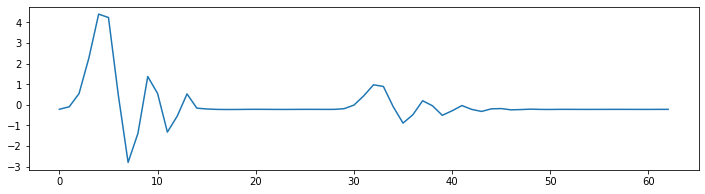

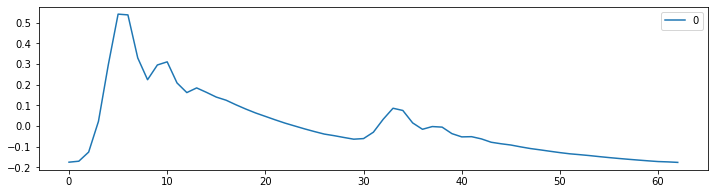

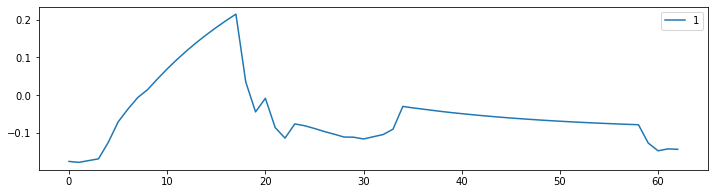

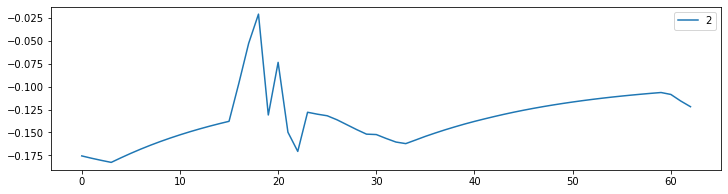

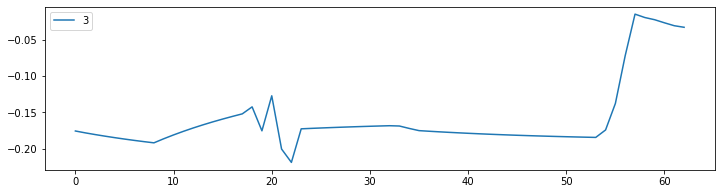

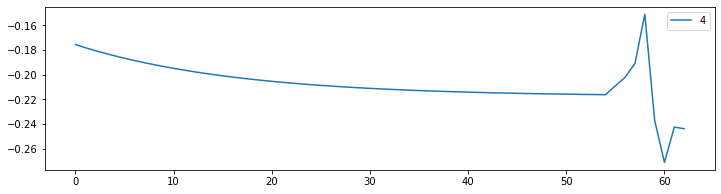

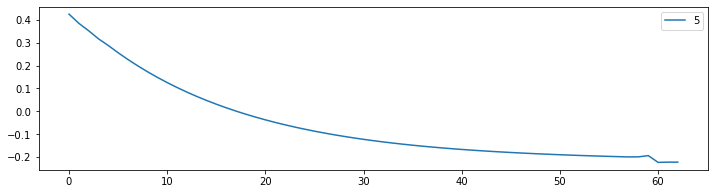

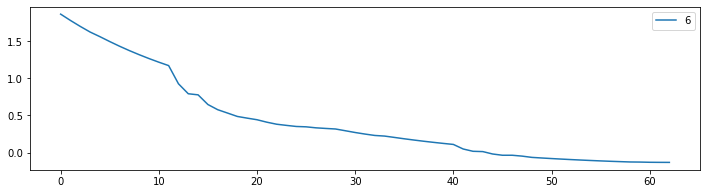

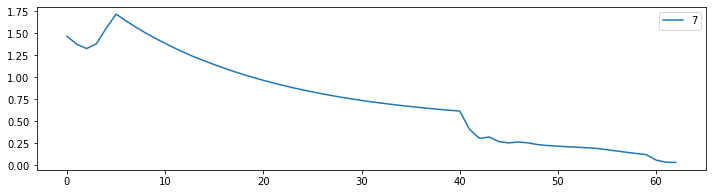

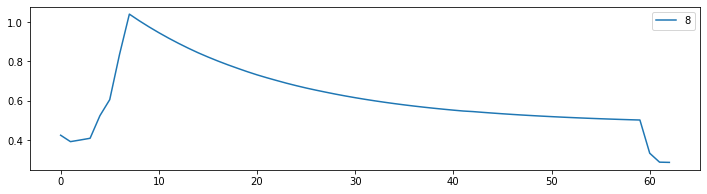

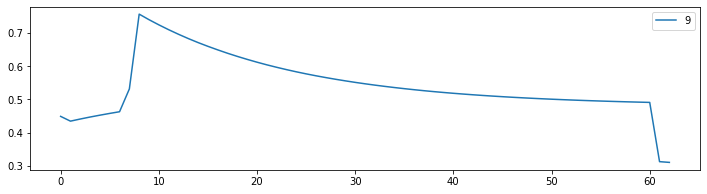

0it [00:03, ?it/s]


ValueError: x, y, and format string must not be None

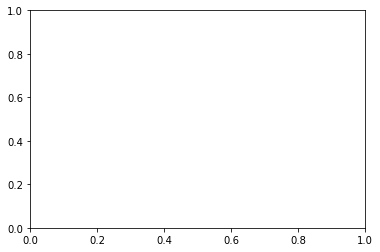

In [79]:
from tqdm import tqdm

def zscore_2d(matrix):
    matrix_mean = matrix.mean(1, keepdims=True)
    matrix_std = matrix.std(1, keepdims=True)
    return (matrix - matrix_mean) / matrix_std

if __name__=='__main__':
    labels_0_train, labels_0_test, signals_0_train, signals_0_test = std_data(0)
    labels_1_train, labels_1_test, signals_1_train, signals_1_test = std_data(0.1)

    def extract_features(signals, labels, alpha, h, d):
        Template_features = []
        idxs = []
        D = []
        for cnt, signal in tqdm(enumerate(signals)):
            hr = labels[cnt, 2]
            ddd = labels[cnt, -1]
            D.append(ddd)

            large_peaks, _ = find_peaks(signal, height=np.max(signal)*0.3, distance=5000//(hr*alpha))
            pieces = segmentation(signal, large_peaks)

            template = performDBA_(pieces,n_iterations=10)
            plt.plot(template)
            features = get_features(template, h, d)
            if features is not None:
                idxs.append(cnt)
                Template_features.append(features)
            break

        return np.array(Template_features), np.array(idxs)

    echo = 10
    template_features_train, idxs_train = extract_features(zscore_2d(signals_0_train), labels_0_train, 1, 0.1, 0.15)
    # template_features_test, idxs_test = extract_features(signals_0_test, labels_0_test, 1.2, 0.12, 0.12, echo)

In [ ]:
def calc_mae(gt, pred):
    return np.mean(abs(np.array(gt) - np.array(pred)))

def plot_2vectors(label, pred, save=False, name=None, path=None):
    """lsit1: label, list2: prediction"""

    list1 = label
    list2 = np.array(pred)
    if list2.ndim == 2:
        mae = calc_mae(list1, list2[:, 0])
    else:
        mae = calc_mae(list1, list2)

    sorted_id = sorted(range(len(list1)), key=lambda k: list1[k])

    plt.clf()
    plt.text(0, np.min(list2), f'MAE={mae}')

    plt.scatter(np.arange(list2.shape[0]), list2[sorted_id], s=1, alpha=0.5, label=f'{name} prediction', color='blue')
    plt.scatter(np.arange(list1.shape[0]), list1[sorted_id], s=1, alpha=0.5, label=f'{name} label', color='red')
    plt.legend(loc='lower right')

    if save:
        if path is None:
            raise ValueError("If save is True, 'path' argument must be provided.")
        plt.savefig(f'{path}.jpg', dpi=300)
        print(f'Saved plot to {path}.jpg')

    plt.show()


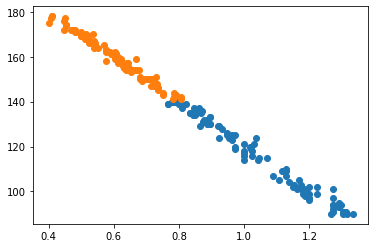

1.8614653543463846


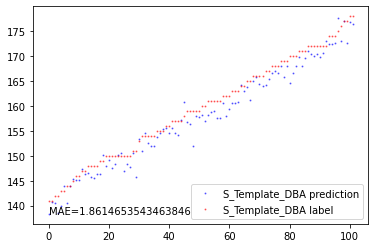

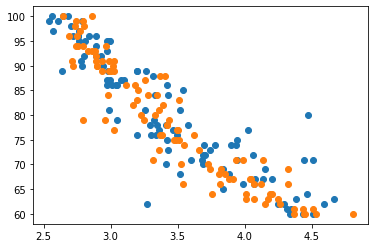

3.6398786177795426


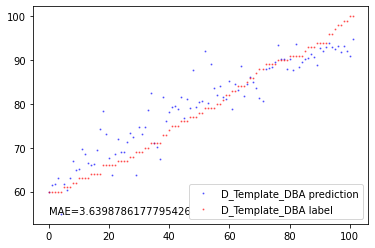

In [29]:
from sklearn.linear_model import LinearRegression as LR
# from Code.Tutorial.utils import plot_2vectors

def plot_plot(features_train, features_test, labels_train, labels_test, title):
    plt.figure()
    plt.scatter(np.array(features_train), labels_train)
    plt.scatter(np.array(features_test), labels_test)
    plt.show()

    reg = LR().fit(np.array(features_train).reshape(-1, 1), labels_train)
    yhat = reg.predict(np.array(features_test).reshape(-1, 1))
    print(np.mean(np.abs(yhat - labels_test)))

    plot_2vectors(labels_test, yhat, False, title)

plot_plot(template_features_train[:, 0],template_features_test[:, 0],labels_0_train[:echo+2, 4],labels_0_test[:echo+2, 4],'S_Template_DBA')
plot_plot(template_features_train[:, 1],template_features_test[:, 1],labels_0_train[:echo+2, 5],labels_0_test[:echo+2, 5],'D_Template_DBA')